## Dataset creation
In this pipeline we will build the final dataset that will be used for classificaiton
- Balance the dataset on repos, datas and labels 
- Create issue msg (prompt)
- Create issue embedding
- Create training ad testing split

In [ ]:
import os

os.chdir("..")
os.getcwd()

In [1]:
import pandas as pd
from datasets import load_dataset

ds = load_dataset("Eathus/cwe_view1003_raw_list", split="train")
cwe_1003_df = ds.to_pandas()

ds = load_dataset("Eathus/github-issues-references", split="train")
positive_df = ds.to_pandas()
display(positive_df.columns)
print(len(positive_df))

ds = load_dataset("Eathus/github-issues-negatives", split="train")
negative_df = ds.to_pandas()

positive_df.issue_owner_repo = positive_df.issue_owner_repo.map(tuple)
negative_df.issue_owner_repo = negative_df.issue_owner_repo.map(tuple)

negative_df = negative_df[
    ~negative_df.issue_github_id.isin(positive_df.issue_github_id)
]

train-00000-of-00001.parquet:   0%|          | 0.00/560k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/130 [00:00<?, ? examples/s]

Index(['cve_id', 'cve_published', 'cve_descriptions', 'cve_metrics',
       'cve_references', 'cve_configurations', 'cve_cwe_list',
       'cve_primary_cwe', 'url', 'cve_tags', 'domain', 'issue_owner_repo',
       'issue_body', 'issue_title', 'issue_comments_url',
       'issue_comments_count', 'issue_created_at', 'issue_updated_at',
       'issue_html_url', 'issue_github_id', 'issue_number'],
      dtype='object')

1250


In [2]:
negative_df["issue_created_at"] = pd.to_datetime(
    negative_df["issue_created_at"], format="%Y-%m-%dT%H:%M:%SZ"
)
positive_df["issue_created_at"] = pd.to_datetime(
    positive_df["issue_created_at"], format="%Y-%m-%dT%H:%M:%SZ"
)

Let's reduce the time window of the issues in the negative dataset. The positive dataset it's made from references created between 01/01/2019 and 01/03/2025. It's so possible to thing that tracking issues created in that period are correctly tracked. 

In this way we want to reduce the chance of untracked issues that are not present in the references list  

In [3]:
import datetime

start_date = datetime.datetime(2021, 1, 1)
end_date = datetime.datetime(2025, 3, 1)

negative_df = negative_df[
    (negative_df.issue_created_at > start_date)
    & (negative_df.issue_created_at < end_date)
]

In [14]:
print(len(negative_df))
print(len(negative_df.drop_duplicates('issue_github_id')))

88335
88335


Let's also remove all the repos that have a too small presence in the negative dataset

In [11]:
vc = negative_df.issue_owner_repo.value_counts()
repos = vc[vc > 75].index

In [ ]:
print(len(positive_df))
negative_df = negative_df[negative_df.issue_owner_repo.isin(repos)]
positive_df = positive_df[positive_df.issue_owner_repo.isin(repos)]
print(len(positive_df))
print(len(positive_df.drop_duplicates('issue_github_id')))
print(len(positive_df.drop_duplicates(['issue_github_id', 'cve_id'])))

duplicate_counts = positive_df['issue_github_id'].value_counts()
duplicate_counts = duplicate_counts[duplicate_counts > 1]
print("Duplicate counts per issue_github_id:")
display(duplicate_counts)

duplicate_counts = positive_df[['issue_github_id', 'cve_id']].value_counts()
duplicate_counts = duplicate_counts[duplicate_counts > 1]
print("Duplicate counts per issue_github_id:")

display(duplicate_counts)

903
903
866
899
Duplicate counts per issue_github_id:


issue_github_id
549961224     13
541977765      8
547887727      7
544834443      7
503095531      2
1646878719     2
1998710063     2
1668648319     2
2057585750     2
1648637134     2
Name: count, dtype: int64

Duplicate counts per issue_github_id:


issue_github_id  cve_id        
1998710063       CVE-2024-8946     2
541977765        CVE-2019-20009    2
2057585750       CVE-2024-8947     2
503095531        CVE-2020-25663    2
Name: count, dtype: int64

In [27]:
inconsistent_mask = (
    positive_df
    .groupby('issue_github_id')['cve_primary_cwe']
    .transform(lambda x: x.nunique() > 1)  # True if 'primary_cwe' varies in the group
)
display(list(positive_df
    .groupby('issue_github_id')['cve_primary_cwe']))

# Step 2: Get the inconsistent duplicates (for inspection)
inconsistent_duplicates = positive_df[inconsistent_mask].sort_values('issue_github_id')

# Step 3: Drop duplicates ONLY where 'primary_cwe' is inconsistent
# (Keep first occurrence where duplicates have the same 'primary_cwe')
consistent_deduped = (
    positive_df
    .sort_values('cve_primary_cwe')  # Optional: Sort to prioritize certain CWE values
    .drop_duplicates(
        subset='issue_github_id',
        keep='first'
    )
)
print(f"Original length: {len(positive_df)}")
print(f"After dropping inconsistent duplicates: {len(consistent_deduped)}")

strict_deduped = positive_df[~inconsistent_mask]
print(len(strict_deduped))

[(128365381,
  143    125
  Name: cve_primary_cwe, dtype: object),
 (128365398,
  144    125
  Name: cve_primary_cwe, dtype: object),
 (151080998,
  488    335
  Name: cve_primary_cwe, dtype: object),
 (248590588,
  39    400
  Name: cve_primary_cwe, dtype: object),
 (249233709,
  38    400
  Name: cve_primary_cwe, dtype: object),
 (257947117,
  1041    476
  Name: cve_primary_cwe, dtype: object),
 (337760000,
  242    674
  Name: cve_primary_cwe, dtype: object),
 (351251936,
  71    787
  Name: cve_primary_cwe, dtype: object),
 (351978078,
  103    400
  Name: cve_primary_cwe, dtype: object),
 (390618242,
  7    787
  Name: cve_primary_cwe, dtype: object),
 (391351147,
  81    476
  Name: cve_primary_cwe, dtype: object),
 (391352422,
  82    125
  Name: cve_primary_cwe, dtype: object),
 (391610142,
  627    770
  Name: cve_primary_cwe, dtype: object),
 (391773951,
  83    401
  Name: cve_primary_cwe, dtype: object),
 (393636374,
  8    119
  Name: cve_primary_cwe, dtype: object),
 (39

Original length: 903
After dropping inconsistent duplicates: 866
866


Now we want to redice the dimension of the negative part of the dataset. One way it's to set a limit of maximum 1200 issues for each repo (the maximum number of reference per repo is 200)

In [8]:
negative_df.issue_owner_repo.count(), positive_df.issue_owner_repo.count()

(np.int64(88335), np.int64(903))

In [31]:
filtered_negative_df = None
ratio = 5

for index, value in zip(
    positive_df.issue_owner_repo.value_counts().index,
    positive_df.issue_owner_repo.value_counts(),
):
    mask = negative_df.issue_owner_repo.map(
        lambda x: True if (index[0] == x[0] and index[1] == x[1]) else False
    )

    tmp = (
        negative_df[mask]
        .sort_values(by="issue_created_at", ascending=False)
        .head(value * ratio)
    )
    if filtered_negative_df is not None:
        filtered_negative_df = pd.concat([filtered_negative_df, tmp], ignore_index=True)
    else:
        filtered_negative_df = tmp.copy()

negative_df = filtered_negative_df
filtered_negative_df.issue_owner_repo.value_counts()

issue_owner_repo
(gpac, gpac)                          1013
(ImageMagick, ImageMagick)             370
(LibreDWG, libredwg)                   345
(axiomatic-systems, Bento4)            312
(jerryscript-project, jerryscript)     258
(kubernetes, kubernetes)               220
(openlink, virtuoso-opensource)        135
(Piwigo, Piwigo)                       120
(cesanta, mjs)                         101
(jeecgboot, jeecg-boot)                100
(libming, libming)                      97
(ChurchCRM, CRM)                        75
(python, cpython)                       65
(dromara, hutool)                       65
(xuxueli, xxl-job)                      60
(MonetDB, MonetDB)                      55
(emqx, nanomq)                          55
(ros-navigation, navigation2)           55
(WebAssembly, wabt)                     55
(llvm, llvm-project)                    40
(MiczFlor, RPi-Jukebox-RFID)            35
(free5gc, free5gc)                      35
(micropython, micropython)           

In [8]:
negative_df.issue_owner_repo.count(), positive_df.issue_owner_repo.count()

(np.int64(88335), np.int64(903))

data len:	 71


,CWE,Proportion
0,787,182
1,476,134
2,125,69
3,89,64
4,401,63
5,617,51
6,416,46
7,120,40
8,770,40
9,79,23


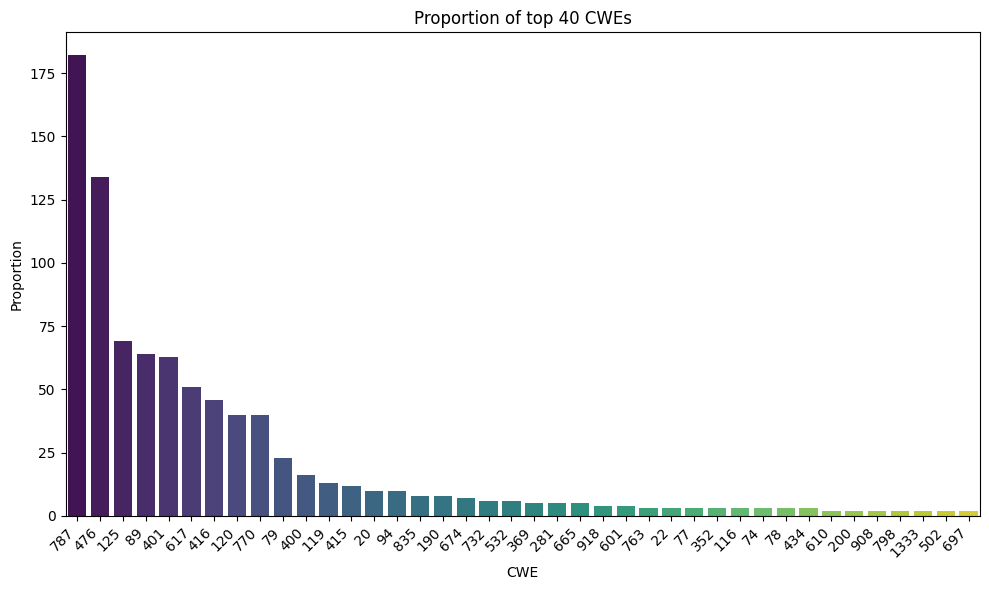

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

k = 40
data = positive_df[positive_df["cve_primary_cwe"].apply(lambda x: x != None)][
    "cve_primary_cwe"
].value_counts(normalize=False)
data_df = data.head(40).reset_index()
data_df.columns = ["CWE", "Proportion"]
print("data len:\t", len(data))
display(data_df.head(10))
# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x="CWE", y="Proportion", hue="CWE", data=data_df, palette="viridis")

# Add labels and title
plt.xticks(rotation=45, ha="right")
plt.title(f"Proportion of top {k} CWEs")

# Show the plot
plt.tight_layout()
plt.show()

## Creating labels and marge 

In [34]:
positive_df["label"] = True
negative_df["label"] = False

In [35]:
display(positive_df.columns)
display(negative_df.columns)

Index(['cve_id', 'cve_published', 'cve_descriptions', 'cve_metrics',
       'cve_references', 'cve_configurations', 'cve_cwe_list',
       'cve_primary_cwe', 'url', 'cve_tags', 'domain', 'issue_owner_repo',
       'issue_body', 'issue_title', 'issue_comments_url',
       'issue_comments_count', 'issue_created_at', 'issue_updated_at',
       'issue_html_url', 'issue_github_id', 'issue_number', 'label'],
      dtype='object')

Index(['issue_owner_repo', 'issue_body', 'issue_title', 'issue_comments_url',
       'issue_comments_count', 'issue_created_at', 'issue_updated_at',
       'issue_html_url', 'issue_github_id', 'issue_number', 'label'],
      dtype='object')

In [36]:
import pandas as pd

positive_df = positive_df.drop(columns=["url", "domain", "cve_cwe_list"])
display(positive_df.columns)
final_df = pd.concat([positive_df, negative_df], axis=0)
final_df.reset_index(drop=True, inplace=True)

Index(['cve_id', 'cve_published', 'cve_descriptions', 'cve_metrics',
       'cve_references', 'cve_configurations', 'cve_primary_cwe', 'cve_tags',
       'issue_owner_repo', 'issue_body', 'issue_title', 'issue_comments_url',
       'issue_comments_count', 'issue_created_at', 'issue_updated_at',
       'issue_html_url', 'issue_github_id', 'issue_number', 'label'],
      dtype='object')

In [37]:
display(final_df.columns)
display(final_df)

Index(['cve_id', 'cve_published', 'cve_descriptions', 'cve_metrics',
       'cve_references', 'cve_configurations', 'cve_primary_cwe', 'cve_tags',
       'issue_owner_repo', 'issue_body', 'issue_title', 'issue_comments_url',
       'issue_comments_count', 'issue_created_at', 'issue_updated_at',
       'issue_html_url', 'issue_github_id', 'issue_number', 'label'],
      dtype='object')

,cve_id,cve_published,cve_descriptions,cve_metrics,cve_references,cve_configurations,cve_primary_cwe,cve_tags,issue_owner_repo,issue_body,issue_title,issue_comments_url,issue_comments_count,issue_created_at,issue_updated_at,issue_html_url,issue_github_id,issue_number,label
0,CVE-2018-20659,2019-01-02T17:29:00.220,An issue was discovered in Bento4 1.5.1-627. T...,"{'cvssMetricV2': [{'acInsufInfo': False, 'base...","[{'source': 'cve@mitre.org', 'tags': ['Exploit...",[{'nodes': [{'cpeMatch': array([{'criteria': '...,770,"[Exploit, Third Party Advisory]","(axiomatic-systems, Bento4)",A crafted input will lead to Memory allocation...,Allocate for large amounts of memory failed in...,https://api.github.com/repos/axiomatic-systems...,2,2018-12-31 15:52:26,2019-01-12T21:14:48Z,https://github.com/axiomatic-systems/Bento4/is...,394998583,350,True
1,CVE-2019-6132,2019-01-11T05:29:01.763,An issue was discovered in Bento4 v1.5.1-627. ...,"{'cvssMetricV2': [{'acInsufInfo': False, 'base...","[{'source': 'cve@mitre.org', 'tags': ['Exploit...",[{'nodes': [{'cpeMatch': array([{'criteria': '...,401,"[Exploit, Third Party Advisory]","(axiomatic-systems, Bento4)",there is memory leaks in Ap4String.cpp\r\n\r\n...,memory leaks in Ap4String.cpp,https://api.github.com/repos/axiomatic-systems...,1,2019-01-10 17:00:31,2019-01-12T09:36:13Z,https://github.com/axiomatic-systems/Bento4/is...,397925621,357,True
2,CVE-2019-6966,2019-01-25T23:29:00.237,An issue was discovered in Bento4 1.5.1-628. T...,"{'cvssMetricV2': [{'acInsufInfo': False, 'base...","[{'source': 'cve@mitre.org', 'tags': ['Exploit...",[{'nodes': [{'cpeMatch': array([{'criteria': '...,770,"[Exploit, Third Party Advisory]","(axiomatic-systems, Bento4)",A crafted input will lead to failed allocate...,failed to allocate LargeMmapAllocator in Ap4A...,https://api.github.com/repos/axiomatic-systems...,1,2019-01-25 07:49:22,2019-12-26T14:50:59Z,https://github.com/axiomatic-systems/Bento4/is...,403042062,361,True
3,CVE-2019-7395,2019-02-05T00:29:00.400,"In ImageMagick before 7.0.8-25, a memory leak ...","{'cvssMetricV2': [{'acInsufInfo': False, 'base...","[{'source': 'cve@mitre.org', 'tags': ['Broken ...",[{'nodes': [{'cpeMatch': array([{'criteria': '...,401,"[Exploit, Patch, Third Party Advisory]","(ImageMagick, ImageMagick)",### Prerequisites\r\n\r\n- [x] I have written ...,memory leak in WritePSDChannel in coders/psd.c,https://api.github.com/repos/ImageMagick/Image...,2,2019-01-17 03:11:55,2019-02-12T01:45:47Z,https://github.com/ImageMagick/ImageMagick/iss...,400092278,1451,True
4,CVE-2019-7396,2019-02-05T00:29:00.447,"In ImageMagick before 7.0.8-25, a memory leak ...","{'cvssMetricV2': [{'acInsufInfo': False, 'base...","[{'source': 'cve@mitre.org', 'tags': ['Broken ...",[{'nodes': [{'cpeMatch': array([{'criteria': '...,401,"[Exploit, Patch, Third Party Advisory]","(ImageMagick, ImageMagick)",### Prerequisites\r\n\r\n- [x] I have written ...,Potential Memory Leak in ReadSIXELImage in cod...,https://api.github.com/repos/ImageMagick/Image...,2,2019-01-17 04:06:51,2019-03-11T01:54:07Z,https://github.com/ImageMagick/ImageMagick/iss...,400102085,1452,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4734,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(espeak-ng, espeak-ng)","Hello,\r\n\r\nWhile working on https://github....",Does WAVE2 processing require wav scaling?,https://api.github.com/repos/espeak-ng/espeak-...,0,2024-12-15 23:20:20,2024-12-15T23:20:20Z,https://github.com/espeak-ng/espeak-ng/issues/...,2740973470,2075,False
4735,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(espeak-ng, espeak-ng)",Speakers\t44 million (2017–2021)\r\n\r\nhttps:...,[FR] Append Pashtoo language please,https://api.github.com/repos/espeak-ng/espeak-...,1,2024-12-06 09:57:44,2025-02-16T07:16:02Z,https://github.com/espeak-ng/espeak-ng/issues/...,2722580509,2051,False
4736,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(espeak-ng, espeak-ng)","While using NVDA 2024.4.1 with eSpeak NG 1.52,...",Strange mispronunciations,https://

# Create issue message and embedding

In [38]:
# import genai
import os
import tiktoken
from pandarallel import pandarallel
from utils import load_prompts

pandarallel.initialize(progress_bar=False)
encoding = tiktoken.encoding_for_model("text-embedding-3-large")
prompts_dict = load_prompts(os.getcwd() + "/prompts")


def foo(x):
    return prompts_dict["issues_display"].format(
        title=x["issue_title"],
        body=x["issue_body"],
        repo_owner=x["issue_owner_repo"][0],
        repo_name=x["issue_owner_repo"][1],
    )

INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [39]:
final_df["issue_msg"] = final_df.parallel_apply(foo, axis=1)
final_df["issue_msg_n_tokens"] = final_df.issue_msg.parallel_map(encoding.encode)
final_df["issue_msg_n_tokens"] = final_df.issue_msg.parallel_map(len)

In [40]:
# remove all entry with a context window > 8191
final_df = final_df[final_df.issue_msg_n_tokens < 8191]

In [41]:
final_df["cve_primary_cwe"] = final_df["cve_primary_cwe"].fillna("No_CWE")
display(final_df[["cve_primary_cwe"]])

,cve_primary_cwe
1,401
3,401
4,401
5,401
6,401
...,...
4734,No_CWE
4735,No_CWE
4736,No_CWE
4737,No_CWE


In [43]:
len(final_df['cve_primary_cwe'].value_counts())
usage_dict_1003 = pd.Series(
    cwe_1003_df.MappingNotes_Usage.values, index=cwe_1003_df.ID
).to_dict()
print(len(final_df[final_df['cve_primary_cwe'].isin(usage_dict_1003)])/len(final_df))

0.1793025871766029


In [38]:
print(len(final_df))
cwe_counts = final_df['cve_primary_cwe'].value_counts()
display(cwe_counts.head())
# Step 2: Filter the DataFrame to include only rows where 'cve_primary_cwe' appears more than once
final_df = final_df[final_df['cve_primary_cwe'].map(cwe_counts) > 2]
print(len(final_df))
print(len(final_df['cve_primary_cwe'].value_counts()))

4445


cve_primary_cwe
No_CWE    3640
787        156
476        120
89          64
125         61
Name: count, dtype: int64

4400
33


In [40]:
display(final_df['cve_primary_cwe'].value_counts())

cve_primary_cwe
No_CWE    3640
787        156
476        120
89          64
125         61
401         51
617         48
120         39
770         36
416         31
79          23
400         14
119         13
415         12
20          10
94          10
190          8
835          7
532          6
732          5
369          5
665          5
601          4
674          4
918          4
22           3
763          3
77           3
352          3
434          3
78           3
116          3
74           3
Name: count, dtype: int64

Let's make an estimate of the cost in embedding, (0.02 per 1M tokens)

In [41]:
(final_df.issue_msg_n_tokens.sum() / 1000000) * 0.02

np.float64(0.17445496)

In [44]:
from utils import *

pandarallel.initialize(progress_bar=True, nb_workers=12)


def create_embedding(msg):
    try:
        return (
            client.embeddings.create(input=msg, model="text-embedding-3-large")
            .data[0]
            .embedding
        )
    except Exception as e:
        print(f"Error processing message: {msg}. Error: {e}")
        return None


final_df["issue_embedding"] = final_df.issue_msg.parallel_map(create_embedding)

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [45]:
final_df.sample(5)

,cve_id,cve_published,cve_descriptions,cve_metrics,cve_references,cve_configurations,cve_primary_cwe,cve_tags,issue_owner_repo,issue_body,...,issue_comments_count,issue_created_at,issue_updated_at,issue_html_url,issue_github_id,issue_number,label,issue_msg,issue_msg_n_tokens,issue_embedding
4360,NaN,NaN,NaN,NaN,NaN,NaN,No_CWE,NaN,"(ros-navigation, navigation2)","<!--\nFor general questions, please ask on Rob...",...,1,2025-02-13 12:48:23,2025-02-13T17:46:50Z,https://github.com/ros-navigation/navigation2/...,2850946803,4918,False,This is a GitHub Issue\nrepo:navigation2\nowne...,3035,"[-0.011350592598319054, 0.0021085701882839203,..."
1974,NaN,NaN,NaN,NaN,NaN,NaN,No_CWE,NaN,"(axiomatic-systems, Bento4)",## Environment \r\nUbuntu 22.04.3 LTS \r\n## C...,...,0,2024-01-29 08:47:19,2024-02-17T17:22:16Z,https://github.com/axiomatic-systems/Bento4/is...,2104961150,921,False,This is a GitHub Issue\nrepo:Bento4\nowner:axi...,7509,"[-0.007885602302849293, 0.013403352349996567, ..."
1865,NaN,NaN,NaN,NaN,NaN,NaN,No_CWE,NaN,"(gpac, gpac)",Extracting Mpeg-4 ASP stream fails using this ...,...,1,2021-04-15 15:55:11,2021-04-16T17:09:57Z,https://github.com/gpac/gpac/issues/1746,859021531,1746,False,This is a GitHub Issue\nrepo:gpac\nowner:gpac\...,2877,"[-0.008600086905062199, 0.04178078845143318, -..."
1407,NaN,NaN,NaN,NaN,NaN,NaN,No_CWE,NaN,"(gpac, gpac)",Thanks for reporting your issue. Please make s...,...,14,2023-02-15 16:16:05,2023-06-26T12:01:07Z,https://github.com/gpac/gpac/issues/2399,1586143458,2399,False,This is a GitHub Issue\nrepo:gpac\nowner:gpac\...,1813,"[-0.0005860996898263693, 0.028806578367948532,..."
4192,NaN,NaN,NaN,NaN,NaN,NaN,No_CWE,NaN,"(xuxueli, xxl-job)",在云原生时代，随着容器化和弹性扩缩容的需求日益增长，我们发现当前 XxlJobExecuto...,...,0,2025-02-12 02:06:20,2025-02-12T02:24:50Z,https://github.com/xuxueli/xxl-job/issues/3654,2846991353,3654,False,This is a GitHub Issue\nrepo:xxl-job\nowner:xu...,1314,"[-0.008026047609746456, -0.027120398357510567,..."


In [46]:
print(len(final_df))

4400


## Create training ad testing split

data len:	 33


,CWE,Proportion
0,No_CWE,3640
1,787,156
2,476,120
3,89,64
4,125,61
5,401,51
6,617,48
7,120,39
8,770,36
9,416,31


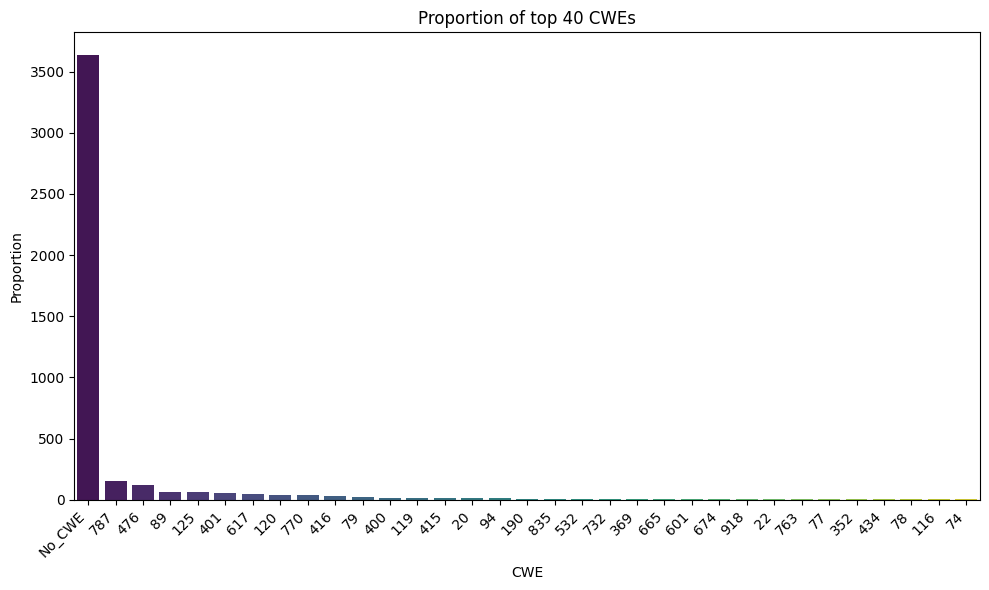

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

k = 40
data = final_df[final_df["cve_primary_cwe"].apply(lambda x: x != None)][
    "cve_primary_cwe"
].value_counts(normalize=False)
data_df = data.head(40).reset_index()
data_df.columns = ["CWE", "Proportion"]
print("data len:\t", len(data))
display(data_df.head(10))
# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x="CWE", y="Proportion", hue="CWE", data=data_df, palette="viridis")

# Add labels and title
plt.xticks(rotation=45, ha="right")
plt.title(f"Proportion of top {k} CWEs")

# Show the plot
plt.tight_layout()
plt.show()

In [48]:
from sklearn.model_selection import train_test_split

final_df["stratify_label"] = (
    final_df["cve_primary_cwe"].astype(str) + "_" + final_df["issue_owner_repo"].astype(str)
)
X_train, X_test = train_test_split(
    final_df, test_size=0.4, random_state=99, stratify=final_df["cve_primary_cwe"]
)

X_train = X_train.drop(columns=["stratify_label"])
X_test = X_test.drop(columns=["stratify_label"])

In [49]:
print(len(X_train[~X_train['cve_primary_cwe'].isin(X_test['cve_primary_cwe'].values)]))

0


In [50]:
X_train.label.mean(), X_test.label.mean()

(np.float64(0.17272727272727273), np.float64(0.17272727272727273))

In [51]:
from datasets import Dataset

# train
ds = Dataset.from_pandas(X_train, preserve_index=True)
ds.push_to_hub("Eathus/github-issues-vul-detection-cwe", split="train")

# test
ds = Dataset.from_pandas(X_test, preserve_index=True)
ds.push_to_hub("Eathus/github-issues-vul-detection-cwe", split="test")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/7.18k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/Eathus/github-issues-vul-detection-cwe/commit/4b7715b03a33ecc1085635e575667f98923c32a9', commit_message='Upload dataset', commit_description='', oid='4b7715b03a33ecc1085635e575667f98923c32a9', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/Eathus/github-issues-vul-detection-cwe', endpoint='https://huggingface.co', repo_type='dataset', repo_id='Eathus/github-issues-vul-detection-cwe'), pr_revision=None, pr_num=None)

# Dataset analysis
- t-SNE visualization

In [52]:
from datasets import load_dataset, concatenate_datasets

dataset_repo = "Eathus/github-issues-vul-detection-cwe"

train_ds = load_dataset(dataset_repo, split="train")
test_ds = load_dataset(dataset_repo, split="test")

combined_ds = concatenate_datasets([train_ds, test_ds])
final_df = combined_ds.to_pandas()

README.md:   0%|          | 0.00/7.28k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/52.5M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/34.9M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2640 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1760 [00:00<?, ? examples/s]

In [53]:
import numpy as np

X = final_df[["issue_embedding"]].values
labels = final_df["label"]

data = []
for i in X:
    data.append(i[0])
X = np.array(data)
X.shape

(4400, 3072)

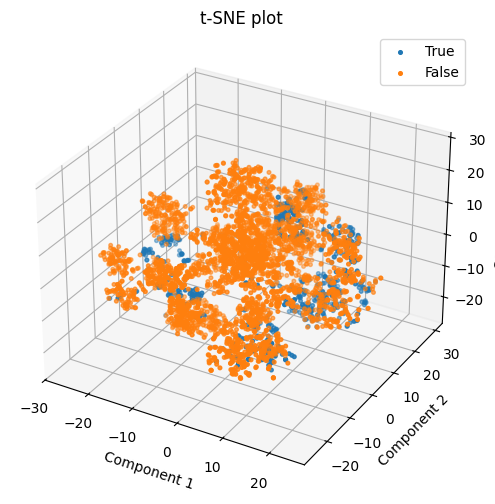

In [54]:
from sklearn.manifold import TSNE
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("default")
tsne = TSNE(n_components=3, random_state=42)
X_tsne = tsne.fit_transform(X)


# Create a DataFrame for the t-SNE result
df_tsne = pd.DataFrame(X_tsne, columns=["Component 1", "Component 2", "Component 3"])
df_tsne["label"] = labels.values

# Plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection="3d")

for label in df_tsne["label"].unique():
    subset = df_tsne[df_tsne["label"] == label]
    ax.scatter(
        subset["Component 1"],
        subset["Component 2"],
        subset["Component 3"],
        label=label,
        s=7,
    )

ax.set_title("t-SNE plot")
ax.set_xlabel("Component 1")
ax.set_ylabel("Component 2")
ax.set_zlabel("Component 3")
ax.legend()
plt.savefig("tsne_plot.pdf", format="pdf", bbox_inches="tight")

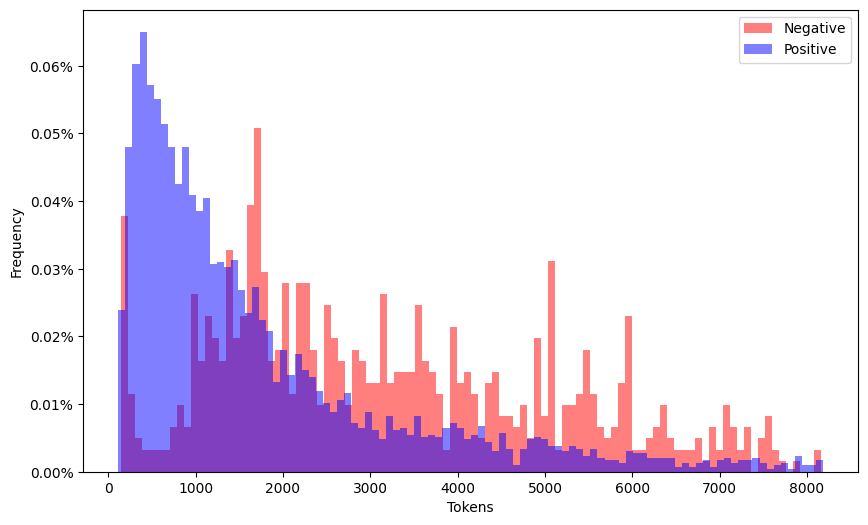

In [55]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Plot the histograms

final_df[final_df.label]["issue_msg_n_tokens"].plot.hist(
    bins=100, alpha=0.5, label="Negative", color="red", density=True
)
final_df[~final_df.label]["issue_msg_n_tokens"].plot.hist(
    bins=100, alpha=0.5, label="Positive", color="blue", density=True
)
plt.legend()

plt.gca().yaxis.set_major_formatter(
    plt.FuncFormatter(lambda y, _: "{:.2f}%".format(y * 100))
)
plt.xlabel("Tokens")
plt.savefig("issue_dimension.png", bbox_inches="tight")